In [1]:
import numpy as np
import torch
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from pyhmc import hmc

In [2]:
# load all mnist data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(990109)
torch.manual_seed(990109)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(784))])
trainset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
data_true = trainset.data.numpy()
data_true = data_true.reshape(data_true.shape[0], -1)

# Add Gaussian noise to dequentize
noise = scs.norm.rvs(0, 0.05, data_true.shape)
X_noisy_flat = (data_true + noise)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in (range(X_noisy_flat.shape[1])):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)


# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 28,28)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# make it a tensor with shape (n_samples, n_channels, height, width)
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 28, 28)

    output:
        original_example: np.array - the original example, of shape (28, 28)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(28, 28) 
    
    return original_example

In [3]:
def waymark(data_p, data_q, alpha):

    if not isinstance(data_p, torch.Tensor):
        data_p = torch.tensor(data_p)
    if not isinstance(data_q, torch.Tensor):
        data_q = torch.tensor(data_q)
    if not isinstance(alpha, torch.Tensor):
        alpha = torch.tensor(alpha)

    if data_p.shape[0] < data_q.shape[0]:
        random_state = np.random.RandomState(42)
        data_p_expand_ = data_p[random_state.choice(data_p.shape[0], data_q.shape[0]-data_p.shape[0], replace=True)]
        data_p_expand = torch.concatenate([data_p_expand_, data_p])
    else:  
        data_p_expand = data_p
    return torch.sqrt(1 - alpha) * data_p_expand + torch.sqrt(alpha) * data_q


In [32]:
# Define the ratio copula for MNIST data (28x28 images)
class W_ratio_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28), normalising_cst=True, c=1.0, reg_lambda=1e-4, W_num=4):
        super(W_ratio_MNIST, self).__init__()
        self.normalising_cst = normalising_cst
        self.reg_lambda = reg_lambda

        if self.normalising_cst:
            self.c = nn.ParameterList([nn.Parameter(torch.tensor(c)) for _ in range(W_num)])


        self.model = nn.Sequential(
            nn.Linear(28*28, 400),  # Adjusted for 28x28 input images
            nn.LeakyReLU(0.2),
            nn.Linear(400, 100),
            nn.LeakyReLU(0.2),
            nn.Linear(100, 100),
            nn.LeakyReLU(0.2)
        )
        self.heads = nn.ModuleList([nn.Linear(100, 1) for _ in range(W_num)])
        self.W_num = W_num

    def forward(self,x):
        x = x.reshape(-1, 28*28)
        log_r = self.model(x)
        out = 0
        for w_idx,head in enumerate(self.heads):
            if self.normalising_cst:
                out += head(log_r) + self.c[w_idx].log()
            else:
                out += head(log_r)
        return out
    
    def forward_train(self,x, w_idx):
        x = x.reshape(-1, 28*28)
        log_r = self.model(x)
        if self.normalising_cst:
            log_r = log_r + self.c[w_idx].log()
        return self.heads[w_idx](log_r)

    def regularizer_logr(self, logr_p, logr_q):
        # Compute the L2 regularization term
        return self.reg_lambda * (torch.sum(logr_p ** 2) + torch.sum(logr_q ** 2))


# Calculate the number of parameters
W_ratio = W_ratio_MNIST(W_num=10)

total_params = sum(p.numel() for p in W_ratio.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 365220


In [25]:
import torch
import torch.nn as nn

# Define the ratio copula for MNIST data (28x28 images)
class W_ratio_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28), normalising_cst=True, c=1.0, reg_lambda=1e-4, W_num=4):
        super(W_ratio_MNIST, self).__init__()
        self.normalising_cst = normalising_cst
        self.reg_lambda = reg_lambda

        if self.normalising_cst:
            self.c = nn.ParameterList([nn.Parameter(torch.tensor(c)) for _ in range(W_num)])


        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 100),  # Adjusted for 28x28 input images
            nn.LeakyReLU(0.2)
        )
        self.heads = nn.ModuleList([nn.Linear(100, 1) for _ in range(W_num)])
        self.W_num = W_num

    def forward(self,x):
        log_r = self.model(x)
        out = 0
        for w_idx,head in enumerate(self.heads):
            if self.normalising_cst:
                out += head(log_r) + self.c[w_idx].log()
            else:
                out += head(log_r)
        return out
    
    def forward_train(self,x, w_idx):
        log_r = self.model(x)
        if self.normalising_cst:
            log_r = log_r + self.c[w_idx].log()
        return self.heads[w_idx](log_r)

    def regularizer_logr(self, logr_p, logr_q):
        # Compute the L2 regularization term
        return self.reg_lambda * (torch.sum(logr_p ** 2) + torch.sum(logr_q ** 2))


#W_ratio.forward_train(torch.randn(1, 1, 28, 28),1)

In [26]:
# Calculate the number of parameters
W_ratio = W_ratio_MNIST(W_num=10)

total_params = sum(p.numel() for p in W_ratio.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 352288


In [36]:
def loss_nce_logsumexp(logr_p, logr_q,p_size, q_size):
    v = q_size / p_size
    # Compute log(v + r_p) and log(v + r_q) using logsumexp for numerical stability
    log_v = torch.log(torch.tensor(v)) * torch.ones_like(logr_p)
    log_v_plus_r_p = torch.logsumexp(torch.stack([log_v, logr_p]), dim=0)
    log_v_plus_r_q = torch.logsumexp(torch.stack([log_v, logr_q]), dim=0)
    # Compute the loss using the numerically stable logsumexp results
    term1 = -(logr_p - log_v_plus_r_p).mean()
    term2 = -v * (log_v - log_v_plus_r_q).mean()
    
    return term1 + term2


In [34]:
from tqdm import tqdm

In [171]:
model_GG_CNN.W_num

2

In [37]:


def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 


# Define model
model_GG_CNN = W_ratio_MNIST(W_num=2,reg_lambda=1e-10)

# Define loss function and optimizer
optimizer = optim.Adam(model_GG_CNN.parameters())#, lr=0.0002, betas=(0.5, 0.999))

n_indep = 1

# Training loop
num_epochs = 2

GG_cov = np.cov(X_train.reshape(-1,28*28).T)

for epoch in tqdm(range(num_epochs)):
    model_GG_CNN.train()
    running_loss = 0.0
    noise_index = 0 

    epoch_GG_noise = torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=100*n_indep).reshape(-1,1,28,28)).float()
    for inputs, labels in (train_loader):
        for w_idx in range(model_GG_CNN.W_num):
            
            optimizer.zero_grad()
            epoch_GG_noise_here = epoch_GG_noise[np.random.choice(epoch_GG_noise.shape[0], inputs.shape[0], replace=False)]
            # 0 is data_p, 1 is data_q
            data_p = waymark(inputs, epoch_GG_noise_here, w_idx/model_GG_CNN.W_num)
            data_q = waymark(inputs, epoch_GG_noise_here, (w_idx+1)/model_GG_CNN.W_num)

            r_p = model_GG_CNN.forward_train(data_p,w_idx).squeeze()
            r_q = model_GG_CNN.forward_train(data_q,w_idx).squeeze()
            noise_index += inputs.shape[0]
            loss = loss_nce_logsumexp(r_p, r_q,data_p.shape[0], data_q.shape[0])
            #loss += model_GG_CNN.regularizer_logr(r_p, r_q)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    if (epoch+1) % 1 == 0:
        c_values = ', '.join([f"c[{idx}]: {param.item()}" for idx, param in enumerate(model_GG_CNN.c)])

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {c_values}, r_p: {r_p.mean().item()}, r_q: {r_q.mean().item()}")



 50%|█████     | 1/2 [00:13<00:13, 13.70s/it]

Epoch 1/2, Loss: 0.32910600959880354, c: c[0]: 0.9403301477432251, c[1]: 1.0619312524795532, r_p: 15.395687103271484, r_q: -8.1253080368042


100%|██████████| 2/2 [00:26<00:00, 13.18s/it]

Epoch 2/2, Loss: 0.5314216039519308, c: c[0]: 0.9409188628196716, c[1]: 1.0901137590408325, r_p: 13.211756706237793, r_q: -8.948314666748047


In [38]:

def compute_logpdf_corrections(X, model, batch_size=64):
    X_flat = X.reshape(-1, 28*28)
    GG_cov = np.cov(X_flat.T)
    GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
    multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor)
    standard_normal = dist.Normal(loc=0, scale=1)

    logpdf_multivariate_sum = 0
    logpdf_standard_sum = 0
    model_log_sum = 0
    total_samples = 0

    for i in tqdm(range(0, X.shape[0], batch_size)):
        X_batch = X[i:i + batch_size]
        X_batch_flat = X_batch.reshape(-1, 28*28)
        logpdf_multivariate_sum += multivariate_normal.log_prob(X_batch_flat).sum().item()
        logpdf_standard_sum += standard_normal.log_prob(X_batch_flat).sum(dim=1).sum().item()
        model_log_sum += model(X_batch).sum().item()
        total_samples += X_batch.shape[0]

    avg_logpdf_multivariate = logpdf_multivariate_sum / total_samples
    avg_logpdf_standard = logpdf_standard_sum / total_samples
    avg_model_log = model_log_sum / total_samples

    GG_correction = avg_logpdf_multivariate - avg_logpdf_standard
    gg_CNN_ratio_corrected = GG_correction + avg_model_log

    return gg_CNN_ratio_corrected,avg_model_log

model_GG_CNN.eval()

# Compute GG ratio corrected for train and test sets
gg_CNN_ratio_corrected_train,gg_CNN_ratio_train = compute_logpdf_corrections(X_train, model_GG_CNN)
gg_CNN_ratio_corrected_test, gg_CNN_ratio_test = compute_logpdf_corrections(X_test, model_GG_CNN)

# Print the results
print('GG CNN ratio base train ; GG_ratio base test', gg_CNN_ratio_train, gg_CNN_ratio_test)
print('GG CNN ratio corrected train ; GG_ratio corrected test', gg_CNN_ratio_corrected_train, gg_CNN_ratio_corrected_test)

# test1 GG CNN ratio corrected train ; GG_ratio corrected test 180.250578092448 179.32892821451833


100%|██████████| 469/469 [00:01<00:00, 275.84it/s]

GG CNN ratio base train ; GG_ratio base test 37.930860546875 37.67798767089844
GG CNN ratio corrected train ; GG_ratio corrected test 175.44310911458342 174.47730902506518


In [39]:

# HMC

def sample_GG_hmc(GG_ratio_model, num_samples, num_runs_hmc, num_burnin):
    ''' 
    Sample from the ratio model with HMC.
    
    args:
        GG_ratio_model: nn.Module - the GG ratio copula model
        num_samples: int - the number of samples to generate per HMC run
        num_runs_hmc: int - the number of HMC runs, each giving num_samples draws
        num_burnin: int - the number of burn-in steps for a single HMC run
    
    returns:
        samples,log_pdf with
        samples: np.array - the generated samples of shape (num_runs_hmc*num_samples, 64)
        log_pdf: np.array - the log-pdf of the samples of shape (num_runs_hmc*num_samples,)
    '''
    GG_ratio_model.eval()
    def log_GGratio_gauss(x):
        ''' 
        Compute the log-pdf of the GG_ratio copula model and its gradient at x. 
        Takes the ratio model and adjusts it by the GG factor to make it into a copula.
        '''
        # compute the top part of a GG_ratio copula logpdf and the gradients of that
        x_tensor = torch.tensor(x.reshape(1, 1, 28, 28), dtype=torch.float32, requires_grad=True)
        x_flat = x_tensor.reshape(-1, 28*28)
        # define N(Sigma) and N(0,1), then compute on x
        GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
        multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor+torch.eye(GG_cov_tensor.size(0))*1e-6)
        standard_normal = dist.Normal(loc=0, scale=1)
        logpdf_multivariate = multivariate_normal.log_prob(x_flat)
        logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
        gg_correction = logpdf_multivariate - logpdf_standard
        # Compute the log of the ratio model
        log_ratio = (GG_ratio_model(x_tensor)).sum()
        # Compute the log probability of x under the standard normal distribution
        log_prob_standard = standard_normal.log_prob(x_tensor).sum()
        # Compute the final function value
        fun = log_ratio + gg_correction + log_prob_standard
        # Backward pass to compute the gradient
        fun.backward()
        grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
        
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    samples = np.zeros((num_runs_hmc, num_samples, 28*28))
    log_pdf = np.zeros((num_runs_hmc, num_samples))
    x0_noise = np.zeros((num_runs_hmc, 28, 28))
    for hmc_run in tqdm( range(num_runs_hmc)):

        '''# pick x0 with highest r(x0) from random noise
        x0_proposal = torch.randn(1000, 1, 28, 28)
        r_noise = model(x0_proposal)
        x0_run = x0_proposal[np.argmax(r_noise.detach().numpy().flatten())]    
        '''
        '''
        # pick x0 randomly from N(0,1) 
        x0_run = torch.randn(1, 1, 28, 28)
        '''
        '''
        # IS from GG
        GG_cov = np.cov(X_train.reshape(-1,28*28).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=10).reshape(-1,1,28,28)
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)
        r_noise = GG_ratio_model(x0_run.reshape(-1,1,28,28))
        log_probs = torch.logsumexp(r_noise, dim=0)# Compute logsumexp normalized probabilities
        probs = torch.exp(r_noise - log_probs)
        x0_run = x0_run[np.random.choice(x0_run.shape[0], 1, replace=False, p = probs.detach().numpy().flatten())]
        '''
        GG_cov = np.cov(X_train.reshape(-1,28*28).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=1).reshape(1,1,28,28)
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)
        samples_, log_pdf_ = hmc(log_GGratio_gauss,
                            x0=x0_run.flatten().numpy(),
                            n_samples=num_samples,
                            return_logp=True,
                            n_burn=num_burnin)
        
        samples[hmc_run] = samples_
        log_pdf[hmc_run] = log_pdf_
        x0_noise[hmc_run] = x0_run

    return samples.reshape(-1,28*28), log_pdf.reshape(-1), x0_noise

sample_GG_CNN, log_pdf, x0_noises = sample_GG_hmc(GG_ratio_model=model_GG_CNN, 
                            num_samples=1, 
                            num_runs_hmc=5,
                            num_burnin=500)
print(sample_GG_CNN.shape)

100%|██████████| 5/5 [01:43<00:00, 20.66s/it]

(5, 784)


In [40]:
def log_GGratio_gauss(GG_ratio_model,x):
        ''' 
        Compute the log-pdf of the GG_ratio copula model and its gradient at x. 
        Takes the ratio model and adjusts it by the GG factor to make it into a copula.
        '''
        # compute the top part of a GG_ratio copula logpdf and the gradients of that
        x_tensor = x.reshape(1, 1, 28, 28)
        x_flat = x_tensor.reshape(-1, 28*28)
        # define N(Sigma) and N(0,1), then compute on x
        GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
        multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor+torch.eye(GG_cov_tensor.size(0))*1e-6)
        standard_normal = dist.Normal(loc=0, scale=1)
        logpdf_multivariate = multivariate_normal.log_prob(x_flat)
        logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
        gg_correction = logpdf_multivariate - logpdf_standard
        # Compute the log of the ratio model
        log_ratio = (GG_ratio_model(x_tensor)).sum()
        # Compute the log probability of x under the standard normal distribution
        log_prob_standard = standard_normal.log_prob(x_tensor).sum()
        # Compute the final function value
        fun = log_ratio + gg_correction #+ log_prob_standard
        
        return fun.item()

sample_pdf = np.array([log_GGratio_gauss(model_GG_CNN,torch.tensor(sample_GG_CNN[k]).float().reshape(-1,1,28,28)) for k in tqdm(range(5))]
)
sample_pdf #array([129.77880859, 110.35611725, 179.03207397, 127.83757019,125.4307251 ]) with 1k burnin
x0_pdf = np.array([log_GGratio_gauss(model_GG_CNN,torch.tensor(x0_noises[k]).float().reshape(-1,1,28,28)) for k in tqdm(range(5))])
print(sample_pdf)
print(x0_pdf)

100%|██████████| 5/5 [00:00<00:00, 50.39it/s]

[685.21899414 808.27392578 535.12286377 417.66949463 656.45684814]
[276.07888794 142.88230896 243.56567383 121.20240021 184.04104614]


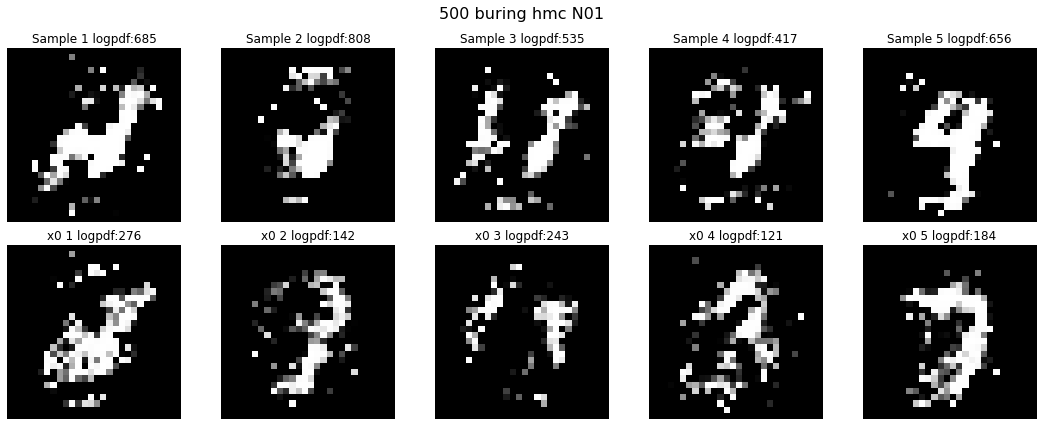

In [41]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, sample_GG_CNN, and x0_noises are already defined

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("500 buring hmc N01", fontsize=16)

for i in range(5):
    # Top row: true samples
    axes[0, i].imshow(reverse_transform(torch.tensor(sample_GG_CNN[i])).reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Sample {i+1} logpdf:'+str(int(sample_pdf[i])))

    # Bottom row: x0 points
    axes[1, i].imshow(reverse_transform(torch.tensor(x0_noises[i])).reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'x0 {i+1} logpdf:'+str(int(x0_pdf[i])))

plt.tight_layout()
plt.show()